# Simple FITS Image Viewer with SEP

This notebook loads a random FITS image from the AstroFiler database and displays it using SEP for star detection.

In [14]:
# Import Required Libraries
import sys
import os
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
import warnings
import sep

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', module='tqdm')

# Configure matplotlib for notebook properly
matplotlib.use('Agg')  # Use non-interactive backend
%matplotlib inline
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (12, 8)
plt.ioff()  # Turn off interactive mode

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [15]:
# Setup Database Connection
sys.path.insert(0, os.path.join(os.path.dirname('.'), 'src'))

from astrofiler.models import fitsFile, fitsSession, db

# Initialize database
db_path = os.path.join(os.path.dirname('.'), 'astrofiler.db')
db.init(db_path)

if not os.path.exists(db_path):
    raise FileNotFoundError(f"Database file not found: {db_path}")

print("✅ Database connected successfully!")

✅ Database connected successfully!


In [16]:
# Function to get a random FITS file
def get_random_fits_file():
    """Get a random LIGHT frame that exists on disk (excludes calibration frames by object name)."""
    
    # Calibration frame keywords to exclude from object names
    calibration_keywords = [
        'bias', 'dark', 'flat', 'Bias', 'Dark', 'Flat', 
        'BIAS', 'DARK', 'FLAT'
    ]
    
    # Get all non-deleted files first
    all_files_query = fitsFile.select().where(
        fitsFile.fitsFileName.is_null(False) &
        (fitsFile.fitsFileSoftDelete == False)
    )
    
    # Find light frames that actually exist on disk
    existing_light_files = []
    for fits_file in all_files_query:
        if fits_file.fitsFileName and os.path.exists(fits_file.fitsFileName):
            
            # Check object name for calibration keywords
            obj_name = fits_file.fitsFileObject or ""
            
            # Skip if object name contains any calibration keywords
            is_calibration = any(keyword.lower() in obj_name.lower() 
                               for keyword in calibration_keywords)
            
            # Only include if it's NOT a calibration frame
            if not is_calibration:
                existing_light_files.append(fits_file)
    
    if not existing_light_files:
        raise FileNotFoundError("No light frame FITS files found on disk")
    
    # Return random light frame
    selected_file = random.choice(existing_light_files)
    print(f"📁 {os.path.basename(selected_file.fitsFileName)}")
    
    return selected_file

print("✅ Light frame function ready!")

✅ Light frame function ready!


In [40]:
# Function to display FITS image with SEP star detection
def display_fits_image(fits_file_obj):
    """Load and display a FITS image - first as large clean image, then with detailed SEP analysis."""
    
    file_path = fits_file_obj.fitsFileName
    
    try:
        # Load FITS file
        with fits.open(file_path) as hdul:
            data = hdul[0].data.astype(np.float64)
            header = hdul[0].header
        
        # Calculate display scaling
        mean, median, std = sigma_clipped_stats(data, sigma=3.0)
        vmin = np.percentile(data, 1)
        vmax = np.percentile(data, 99.5)
        
        # FIRST: Show large, clean image without any annotations
        fig1, ax = plt.subplots(1, 1, figsize=(16, 12))
        
        # Image title
        title = f"{fits_file_obj.fitsFileObject} - {fits_file_obj.fitsFileFilter} filter"
        title += f"\n{fits_file_obj.fitsFileTelescop} - {fits_file_obj.fitsFileExpTime}s exposure"
        fig1.suptitle(title, fontsize=16)
        
        # Display clean image
        im = ax.imshow(data, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
        ax.set_title('', fontsize=14)  # No subtitle, keep it clean
        ax.set_xlabel('X (pixels)', fontsize=12)
        ax.set_ylabel('Y (pixels)', fontsize=12)
        
        # Add colorbar
        plt.colorbar(im, ax=ax, shrink=0.8, label='Pixel Value')
        
        # Add minimal image info
        info_text = f"Size: {data.shape[1]} × {data.shape[0]} pixels"
        ax.text(0.02, 0.02, info_text, transform=ax.transAxes, 
                color='white', fontweight='bold', fontsize=11,
                bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
        
        plt.tight_layout()
        
        # Display the clean image first
        from IPython.display import display
        display(fig1)
        plt.close(fig1)  # Clean up
        
        # SECOND: Show detailed analysis with side-by-side comparison
        fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
        fig2.suptitle("Detailed Star Detection Analysis", fontsize=14)
        
        # Left image: Original without circles
        im1 = ax1.imshow(data, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
        ax1.set_title('Original Image', fontsize=12)
        ax1.set_xlabel('X (pixels)')
        ax1.set_ylabel('Y (pixels)')
        
        # Right image: With star detection circles
        im2 = ax2.imshow(data, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
        ax2.set_title('With SEP Star Detection', fontsize=12)
        ax2.set_xlabel('X (pixels)')
        ax2.set_ylabel('Y (pixels)')
        
        # Add colorbars
        plt.colorbar(im1, ax=ax1, shrink=0.8, label='Pixel Value')
        plt.colorbar(im2, ax=ax2, shrink=0.8, label='Pixel Value')
        
        # Star detection using SEP
        from matplotlib.patches import Circle
        
        try:
            # Prepare data for SEP (needs to be C-contiguous)
            data_sep = data.copy(order='C')
            
            # Subtract background
            bkg = sep.Background(data_sep)
            data_sub = data_sep - bkg
            
            # SEP detection parameters
            threshold = 5.0  # Detection threshold in units of background RMS
            minarea = 5      # Minimum area in pixels
            
            print(f"🔍 SEP: thresh={threshold}*sigma, minarea={minarea}px")
            
            # Extract sources
            objects = sep.extract(data_sub, threshold, err=bkg.globalrms, minarea=minarea)
            
            if len(objects) > 0:
                print(f"⭐ SEP detected {len(objects)} sources")
                
                # Calculate FWHM and eccentricity for each source
                try:
                    # Filter out sources with invalid ellipse parameters
                    valid_mask = (objects['a'] > 0) & (objects['b'] > 0) & np.isfinite(objects['a']) & np.isfinite(objects['b'])
                    valid_objects = objects[valid_mask]
                    
                    if len(valid_objects) == 0:
                        raise ValueError("No sources with valid ellipse parameters")
                    
                    print(f"📊 {len(valid_objects)} of {len(objects)} sources have valid parameters")
                    
                    # Calculate Kron radius for flux measurements (only for valid objects)
                    kronrad, krflag = sep.kron_radius(data_sub, valid_objects['x'], valid_objects['y'], 
                                                     valid_objects['a'], valid_objects['b'], valid_objects['theta'], 6.0)
                    
                    # Use minimum radius for failed Kron calculations
                    kronrad = np.maximum(kronrad, 2.5)  # Minimum radius of 2.5 pixels
                    
                    # Calculate flux within Kron apertures
                    flux, fluxerr, flag = sep.sum_ellipse(data_sub, valid_objects['x'], valid_objects['y'], 
                                                         valid_objects['a'], valid_objects['b'], valid_objects['theta'], 
                                                         2.5*kronrad, subpix=1, err=bkg.globalrms)
                    
                    # Calculate FWHM from semi-major and semi-minor axes
                    # FWHM = 2 * sqrt(2 * ln(2)) * sqrt(a * b) for elliptical Gaussian
                    fwhm = 2.0 * np.sqrt(2.0 * np.log(2.0)) * np.sqrt(valid_objects['a'] * valid_objects['b'])
                    
                    # Calculate eccentricity: e = sqrt(1 - (b/a)^2)
                    eccentricity = np.sqrt(1.0 - (valid_objects['b'] / valid_objects['a'])**2)
                    
                    # Calculate Half Flux Radius (HFR) - approximation using sqrt(a*b)
                    # HFR is the radius that contains half the flux of the star
                    hfr = np.sqrt(valid_objects['a'] * valid_objects['b'])
                    
                    # Create arrays for all objects (valid and invalid)
                    all_fwhm = np.full(len(objects), np.nan)
                    all_eccentricity = np.full(len(objects), np.nan)
                    all_hfr = np.full(len(objects), np.nan)
                    all_flux = np.full(len(objects), np.nan)
                    
                    # Fill in values for valid objects
                    all_fwhm[valid_mask] = fwhm
                    all_eccentricity[valid_mask] = eccentricity
                    all_hfr[valid_mask] = hfr
                    all_flux[valid_mask] = flux
                    
                    # Add new fields to objects structured array
                    import numpy.lib.recfunctions as rfn
                    objects = rfn.append_fields(objects, 'fwhm', all_fwhm)
                    objects = rfn.append_fields(objects, 'eccentricity', all_eccentricity)
                    objects = rfn.append_fields(objects, 'hfr', all_hfr)
                    objects = rfn.append_fields(objects, 'flux_kron', all_flux)
                    
                    print(f"📊 Calculated FWHM, HFR, and eccentricity for {np.sum(~np.isnan(all_fwhm))} sources")
                    
                except Exception as calc_error:
                    print(f"⚠️ Warning: Could not calculate FWHM/HFR/eccentricity: {calc_error}")
                    # Add dummy fields if calculation fails
                    import numpy.lib.recfunctions as rfn
                    fwhm = np.full(len(objects), np.nan)
                    eccentricity = np.full(len(objects), np.nan)
                    hfr = np.full(len(objects), np.nan)
                    flux = np.full(len(objects), np.nan)
                    objects = rfn.append_fields(objects, 'fwhm', fwhm)
                    objects = rfn.append_fields(objects, 'eccentricity', eccentricity)
                    objects = rfn.append_fields(objects, 'hfr', hfr)
                    objects = rfn.append_fields(objects, 'flux_kron', flux)
                
                # Sort by flux (brightest first) for better display
                # Use valid flux values, put invalid ones at the end
                valid_flux_mask = ~np.isnan(objects['flux_kron'])
                if np.any(valid_flux_mask):
                    # Sort valid fluxes first, then invalid ones
                    valid_indices = np.where(valid_flux_mask)[0]
                    invalid_indices = np.where(~valid_flux_mask)[0]
                    
                    # Sort valid ones by flux (descending)
                    valid_sorted = valid_indices[np.argsort(objects['flux_kron'][valid_indices])[::-1]]
                    
                    # Combine: valid (sorted by flux) + invalid
                    flux_sort_idx = np.concatenate([valid_sorted, invalid_indices])
                else:
                    # All flux values are invalid, just use original order
                    flux_sort_idx = np.arange(len(objects))
                
                objects_sorted = objects[flux_sort_idx]
                
                # Draw circles around detected sources (only on right image)
                circle_radius = 10  # Fixed radius for visibility
                stars_drawn = 0
                measurements = []  # Store measurements for display
                
                for i, obj in enumerate(objects_sorted):
                    x, y = obj['x'], obj['y']
                    
                    # Check if source is within image bounds
                    if (10 <= x < data.shape[1] - 10 and 
                        10 <= y < data.shape[0] - 10):
                        
                        # Draw red circle around source (only on right image)
                        circle = Circle((x, y), radius=circle_radius, 
                                      color='red', fill=False, linewidth=2, alpha=0.8)
                        ax2.add_patch(circle)
                        
                        # Store measurements for brightest stars (limit to first 10)
                        if stars_drawn < 10:
                            measurements.append({
                                'id': stars_drawn + 1,
                                'x': x,
                                'y': y,
                                'fwhm': obj['fwhm'] if not np.isnan(obj['fwhm']) else 'N/A',
                                'hfr': obj['hfr'] if not np.isnan(obj['hfr']) else 'N/A',
                                'ecc': obj['eccentricity'] if not np.isnan(obj['eccentricity']) else 'N/A',
                                'flux': obj['flux_kron'] if not np.isnan(obj['flux_kron']) else 'N/A'
                            })
                        
                        stars_drawn += 1
                
                # Add info text to right image
                info_text = f"{stars_drawn} sources detected"
                if measurements:
                    # Filter valid measurements for averages
                    valid_fwhm = [m['fwhm'] for m in measurements if m['fwhm'] != 'N/A' and not np.isnan(m['fwhm'])]
                    valid_hfr = [m['hfr'] for m in measurements if m['hfr'] != 'N/A' and not np.isnan(m['hfr'])]
                    valid_ecc = [m['ecc'] for m in measurements if m['ecc'] != 'N/A' and not np.isnan(m['ecc'])]
                    
                    if valid_fwhm:
                        avg_fwhm = np.mean(valid_fwhm)
                        info_text += f"\nAvg FWHM: {avg_fwhm:.1f}px"
                    if valid_hfr:
                        avg_hfr = np.mean(valid_hfr)
                        info_text += f"\nAvg HFR: {avg_hfr:.1f}px"
                    if valid_ecc:
                        avg_ecc = np.mean(valid_ecc)
                        info_text += f"\nAvg Ecc: {avg_ecc:.2f}"
                
                ax2.text(0.02, 0.98, info_text, 
                        transform=ax2.transAxes, color='red', fontweight='bold',
                        verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='black', alpha=0.8))
                
                # Print detailed measurements for brightest stars
                if measurements:
                    # Calculate and display averages first
                    valid_fwhm = [m['fwhm'] for m in measurements if m['fwhm'] != 'N/A' and not np.isnan(m['fwhm'])]
                    valid_hfr = [m['hfr'] for m in measurements if m['hfr'] != 'N/A' and not np.isnan(m['hfr'])]
                    valid_ecc = [m['ecc'] for m in measurements if m['ecc'] != 'N/A' and not np.isnan(m['ecc'])]
                    
                    print(f"\n📊 Image Statistics (top {len(measurements)} sources):")
                    if valid_fwhm:
                        avg_fwhm = np.mean(valid_fwhm)
                        print(f"   Average FWHM: {avg_fwhm:.2f} pixels ({len(valid_fwhm)} valid)")
                    else:
                        print("   Average FWHM: N/A (no valid measurements)")
                    if valid_hfr:
                        avg_hfr = np.mean(valid_hfr)
                        print(f"   Average HFR: {avg_hfr:.2f} pixels ({len(valid_hfr)} valid)")
                    else:
                        print("   Average HFR: N/A (no valid measurements)")
                    if valid_ecc:
                        avg_ecc = np.mean(valid_ecc)
                        print(f"   Average Eccentricity: {avg_ecc:.3f} ({len(valid_ecc)} valid)")
                    else:
                        print("   Average Eccentricity: N/A (no valid measurements)")
                    
                    print("\n🌟 Brightest Sources Measurements:")
                    print("ID   X      Y      FWHM   HFR    Ecc    Flux")
                    print("-" * 48)
                    for m in measurements:
                        fwhm_str = f"{m['fwhm']:.1f}" if m['fwhm'] != 'N/A' and not np.isnan(m['fwhm']) else 'N/A'
                        hfr_str = f"{m['hfr']:.1f}" if m['hfr'] != 'N/A' and not np.isnan(m['hfr']) else 'N/A'
                        ecc_str = f"{m['ecc']:.2f}" if m['ecc'] != 'N/A' and not np.isnan(m['ecc']) else 'N/A'
                        flux_str = f"{m['flux']:.0f}" if m['flux'] != 'N/A' and not np.isnan(m['flux']) else 'N/A'
                        print(f"{m['id']:2d}  {m['x']:6.1f} {m['y']:6.1f} {fwhm_str:>5s}  {hfr_str:>5s}  {ecc_str:>5s} {flux_str:>7s}")
                    
                        
            else:
                print("⚠️ SEP detected no sources")
                ax2.text(0.02, 0.98, "No sources detected", 
                        transform=ax2.transAxes, color='yellow', fontweight='bold',
                        verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='black', alpha=0.8))
                
        except Exception as e:
            print(f"⚠️ SEP detection error: {e}")
            ax2.text(0.02, 0.98, f"SEP detection failed", 
                    transform=ax2.transAxes, color='orange', fontweight='bold',
                    verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='black', alpha=0.8))
        
        # Add image info to both images
        info_text = f"Size: {data.shape[1]} × {data.shape[0]} pixels"
        ax1.text(0.02, 0.02, info_text, transform=ax1.transAxes, 
                color='white', fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
        ax2.text(0.02, 0.02, info_text, transform=ax2.transAxes, 
                color='white', fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
        
        plt.tight_layout()
        
        # Display the analysis figure
        display(fig2)
        plt.close(fig2)  # Clean up to prevent memory leaks
        
    except Exception as e:
        print(f"❌ Error loading image: {e}")
        return None

print("✅ SEP display function ready!")

✅ SEP display function ready!


## 🎯 Load and Display Random Image with SEP

Run the cell below to load and display a random FITS image from your database using SEP for star detection!

📁 Alnitak-S30_4b2ec06b-Seestar_S30-LP-20250209034126-10.0s-1x1-t-6.625.fits


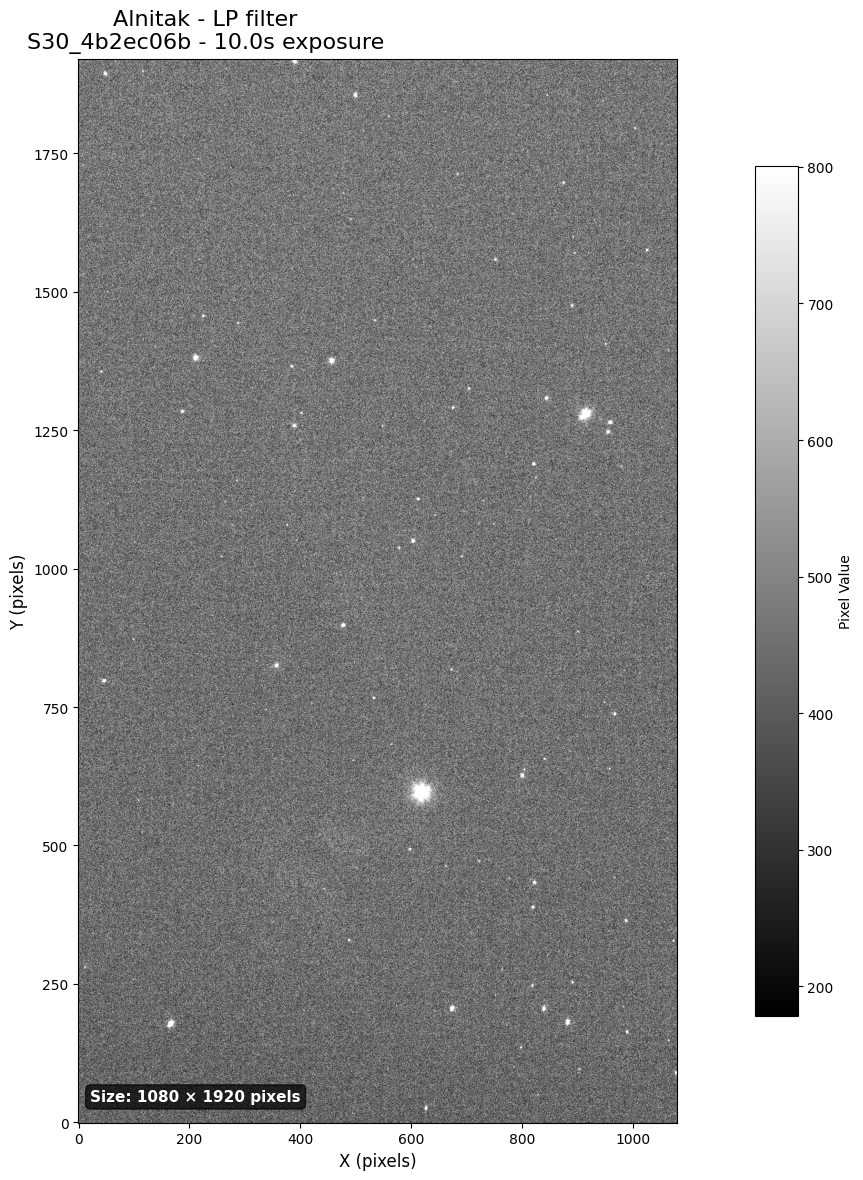

🔍 SEP: thresh=5.0*sigma, minarea=5px
⭐ SEP detected 46 sources
📊 46 of 46 sources have valid parameters
📊 Calculated FWHM, HFR, and eccentricity for 46 sources

📊 Image Statistics (top 10 sources):
   Average FWHM: 3.72 pixels (10 valid)
   Average HFR: 1.58 pixels (10 valid)
   Average Eccentricity: 0.476 (10 valid)

🌟 Brightest Sources Measurements:
ID   X      Y      FWHM   HFR    Ecc    Flux
------------------------------------------------
 1   618.9  596.4   8.2    3.5   0.45 4689845
 2   915.2 1279.9   5.0    2.1   0.54 2209492
 3   908.0 1273.0   3.0    1.3   0.44  551108
 4   166.4  178.5   3.6    1.5   0.76  449670
 5   457.1 1375.2   3.1    1.3   0.27  429374
 6   211.8 1380.5   2.9    1.2   0.29  356870
 7   673.9  205.7   3.0    1.3   0.63  245796
 8   882.5  181.5   3.0    1.3   0.60  225179
 9   800.5  626.5   2.7    1.2   0.32  138006
10   477.6  897.7   2.7    1.1   0.44  134498


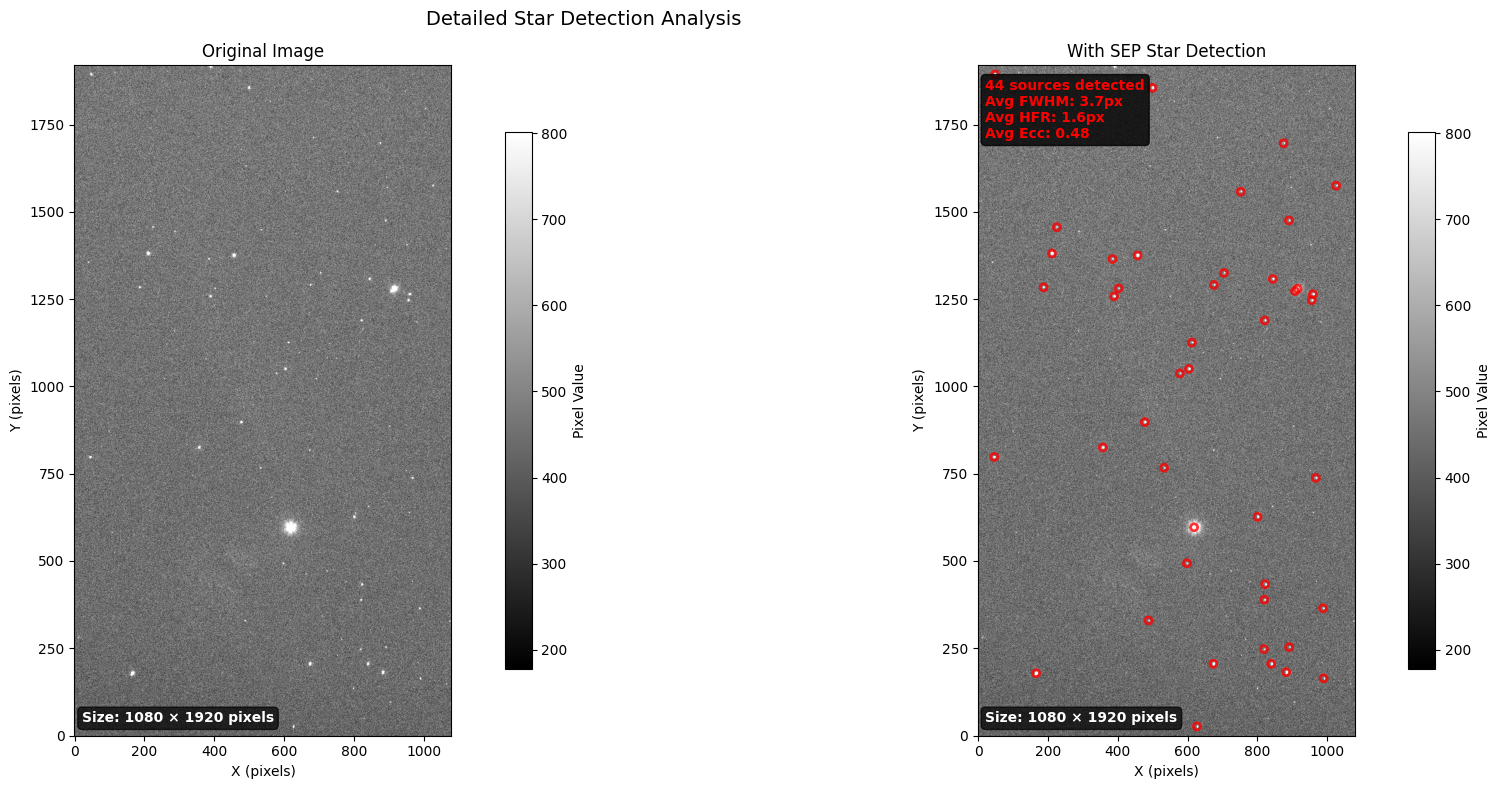

In [53]:
# Load and display a random image
random_file = get_random_fits_file()
display_fits_image(random_file)